In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import timm

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [24]:
class PlayingCardDataset(Dataset):
  def __init__(self, data_dir, transform=None):
    self.data = ImageFolder(root=data_dir, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

  @property
  def classes(self):
    return self.data.classes

In [25]:
dataset = PlayingCardDataset(data_dir='cards/train')

In [26]:
len(dataset)

7624

0


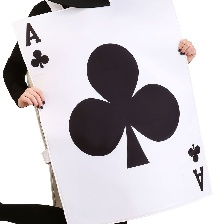

In [30]:
image, label = dataset[0]
print(label)
image

In [32]:
data_dir = 'cards/train'
target_to_class = {v: k for k, v in ImageFolder(root=data_dir).class_to_idx.items()}
print(target_to_class)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

In [39]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

data_dir = 'cards/train'
dataset = PlayingCardDataset(data_dir=data_dir, transform=transform)

In [40]:
image, label = dataset[100]
image.shape

torch.Size([3, 128, 128])

In [41]:
for image, label in dataset:
  break

## Dataloaders
Batching dataset

In [43]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [44]:
for images, labels in dataloader:
  break

In [46]:
images.shape, labels.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32]))

In [47]:
labels

tensor([18, 41, 43,  9, 40, 27, 10, 22, 46, 41,  5, 37, 48,  0, 20, 19, 33, 28,
        30, 12, 36, 19,  7,  5, 44,  7, 21, 39, 32, 14, 35, 18])

## Pytorch Model
- could create model from scratch defining each layer
- but for tasks like image classification, many state-of-the-art architectures are readily available and we can import then from packages like timm
- understanding the pytorch model is all about understanding the shape the data is at each layer, and the main one we need to modify for a task is the final layer. here we have 53 targets, so we will modify the last layer

In [73]:
class SimpleCardClassifier(nn.Module):
  def __init__(self, num_classes=53):
    # where we define parts of model
    super(SimpleCardClassifier, self).__init__()
    self.base_model = timm.create_model('efficientnet_b0', pretrained=True)
    self.features = nn.Sequential(*list(self.base_model.children())[:-1])

    enet_out_size = 1280
    # make a classifier
    self.classifier = nn.Sequential(nn.Flatten(), nn.Linear(enet_out_size, num_classes))

  def forward(self, x):
    # connect parts and return output
    x = self.features(x)                # [B, 1280, H, W]
    output = self.classifier(x)
    return output

In [74]:
model = SimpleCardClassifier(num_classes=53)
print(str(model)[:500])

SimpleCardClassifier(
  (base_model): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=Fa


In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleCardClassifier(num_classes=53)
model.to(device) # move the model to the device
example_out = model(images)
example_out.shape

torch.Size([9, 53])

## Training Loop
- need to create process of training model
- consider: we want to validate our model on data it has not been trained on, so usually we split data into train and validate datasets. easy because we can just create two datasets using our existing class
  - epoch: one run through the entire training dataset
  - step: one batch of data as defined in our dataloader
- loop: load in data to the model in batches, then calculate the loss and perform backpropagation. there are packages that package this for you, but it's good to have at least written it once to understand how it works
- 2 things to select: optimizer - adam is best place to start for most tasks, loss function - what the model will optimize for

In [76]:
criterion = nn.CrossEntropyLoss() # loss fnc
optimizer = optim.Adam(model.parameters(), lr=0.001) # optimizer

In [77]:
criterion(example_out, labels)

tensor(4.0574, device='cuda:0', grad_fn=<NllLossBackward0>)

## Set Up Datasets

In [78]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

train_folder = 'cards/train'
valid_folder = 'cards/valid'
test_folder = 'cards/test'

train_dataset = PlayingCardDataset(data_dir=train_folder, transform=transform)
valid_dataset = PlayingCardDataset(data_dir=valid_folder, transform=transform)
test_dataset = PlayingCardDataset(data_dir=test_folder, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [81]:
num_epochs = 5
train_losses, val_losses = [], []

model = SimpleCardClassifier(num_classes=53)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  for images, labels in tqdm(train_loader, desc="training loop"):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item() * images.size(0)
  train_loss = running_loss / len(train_loader.dataset)
  train_losses.append(train_loss)

  # validation phase
  model.eval()
  running_loss = 0.0
  with torch.no_grad():
    for images, labels in tqdm(valid_loader, desc="validation loop"):
      images, labels = images.to(device), labels.to(device) # Move images and labels to the device
      outputs = model(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item() * images.size(0)
    val_loss = running_loss / len(valid_loader.dataset)
    val_losses.append(val_loss)

  print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5, Train Loss: 1.5487, Val Loss: 0.4709


training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5, Train Loss: 0.5547, Val Loss: 0.2173


training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5, Train Loss: 0.3358, Val Loss: 0.3954


training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5, Train Loss: 0.2372, Val Loss: 0.1707


training loop:   0%|          | 0/239 [00:00<?, ?it/s]

validation loop:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5, Train Loss: 0.1715, Val Loss: 0.2396


## Visualize Losses

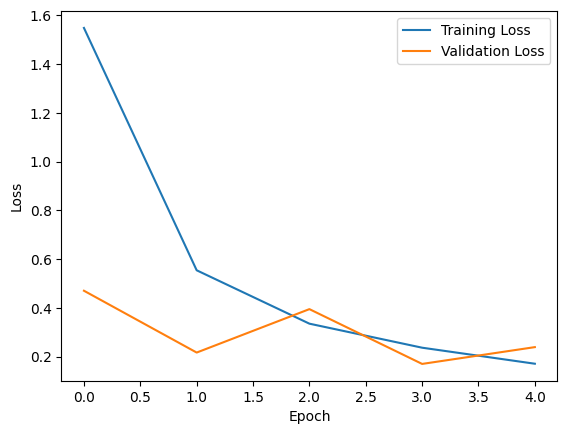

In [82]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluating Results

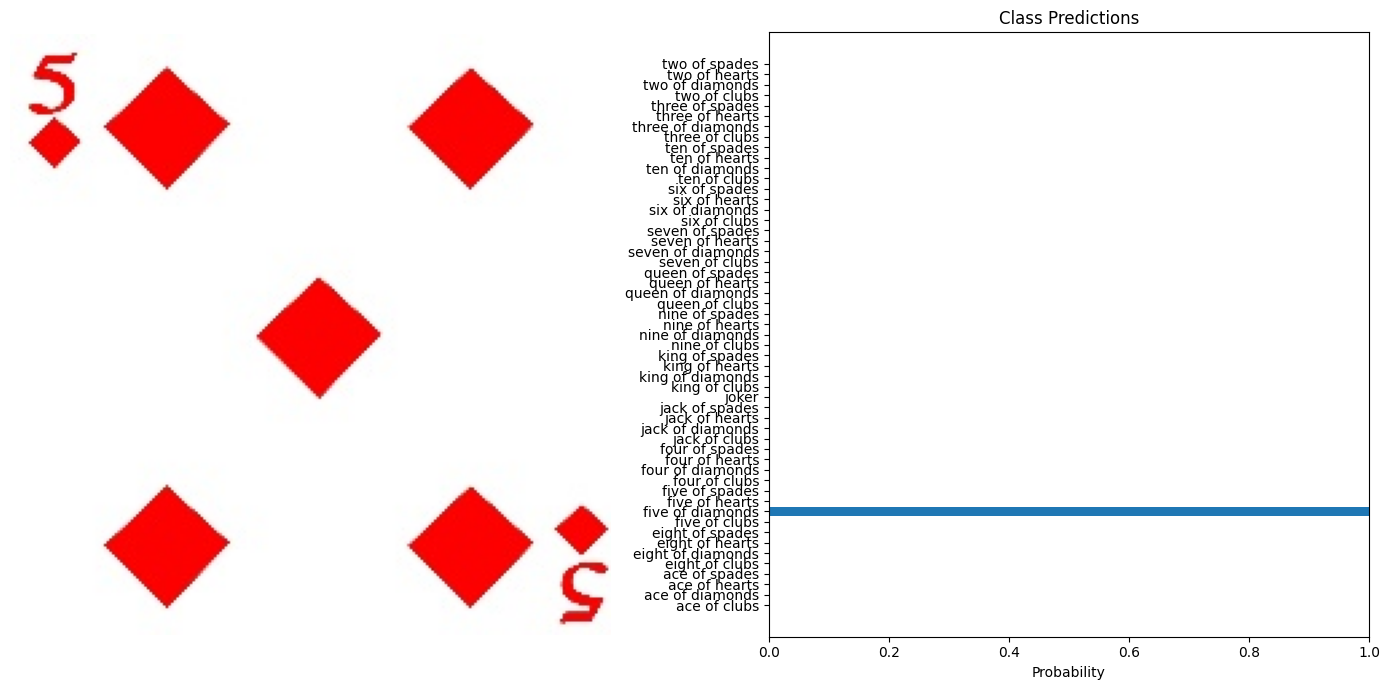

In [83]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# load and preprocess the image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# predict using the model
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        return probabilities.cpu().numpy().flatten()

# visualization
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize=(14, 7))

    # display image
    axarr[0].imshow(original_image)
    axarr[0].axis("off")

    # display predictions
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probability")
    axarr[1].set_title("Class Predictions")
    axarr[1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

# example usage
test_image = "cards/test/five of diamonds/2.jpg"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

# assuming dataset.classes gives the class names
class_names = dataset.classes
visualize_predictions(original_image, probabilities, class_names)

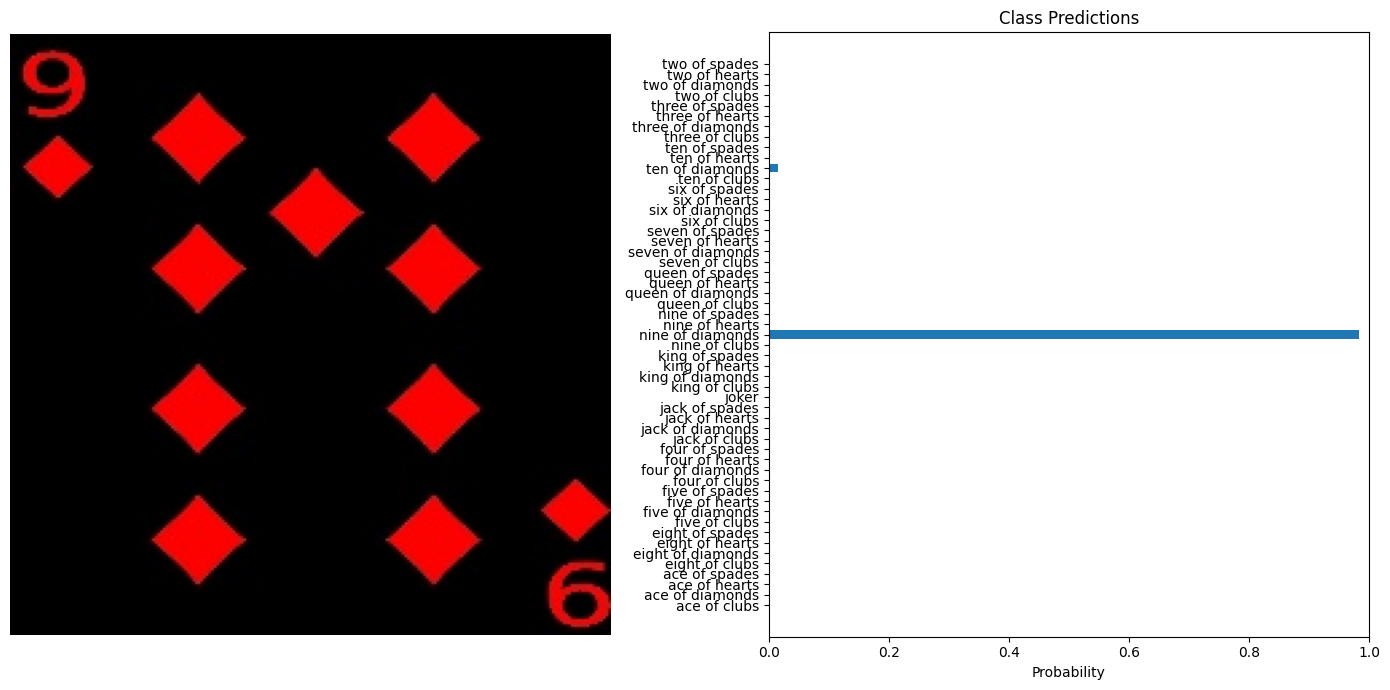

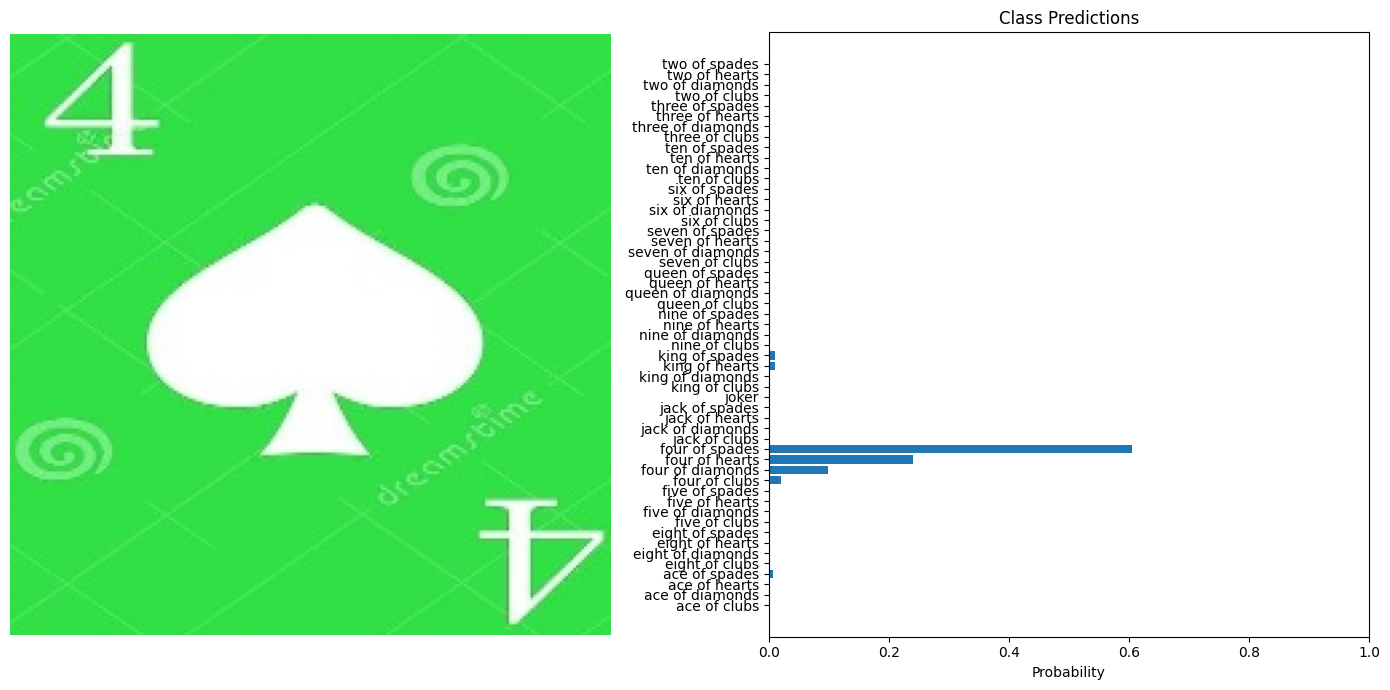

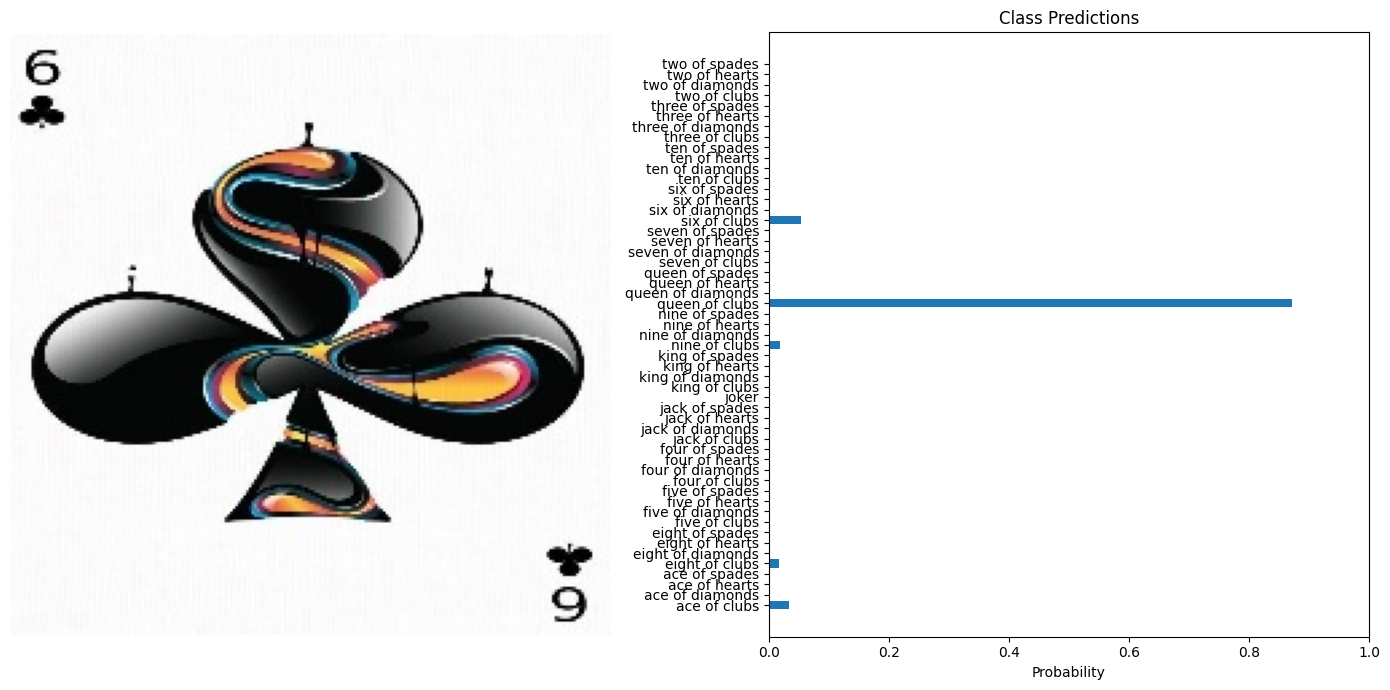

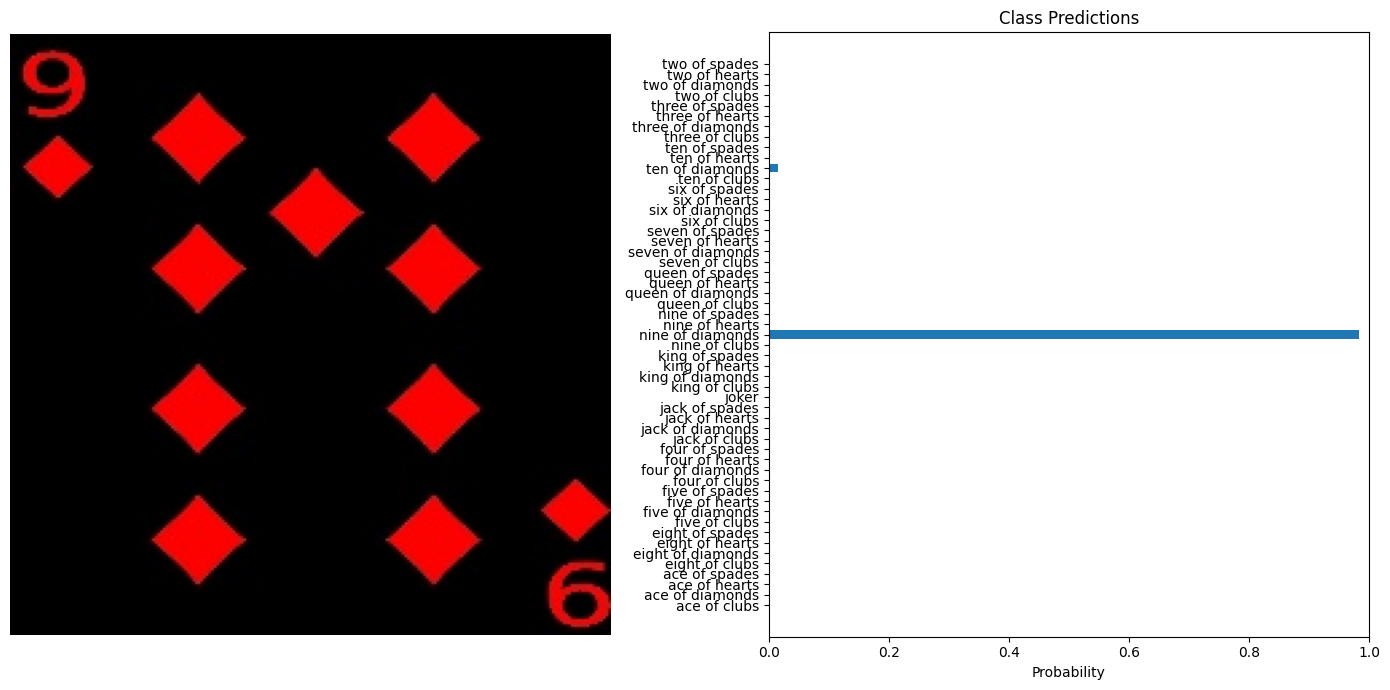

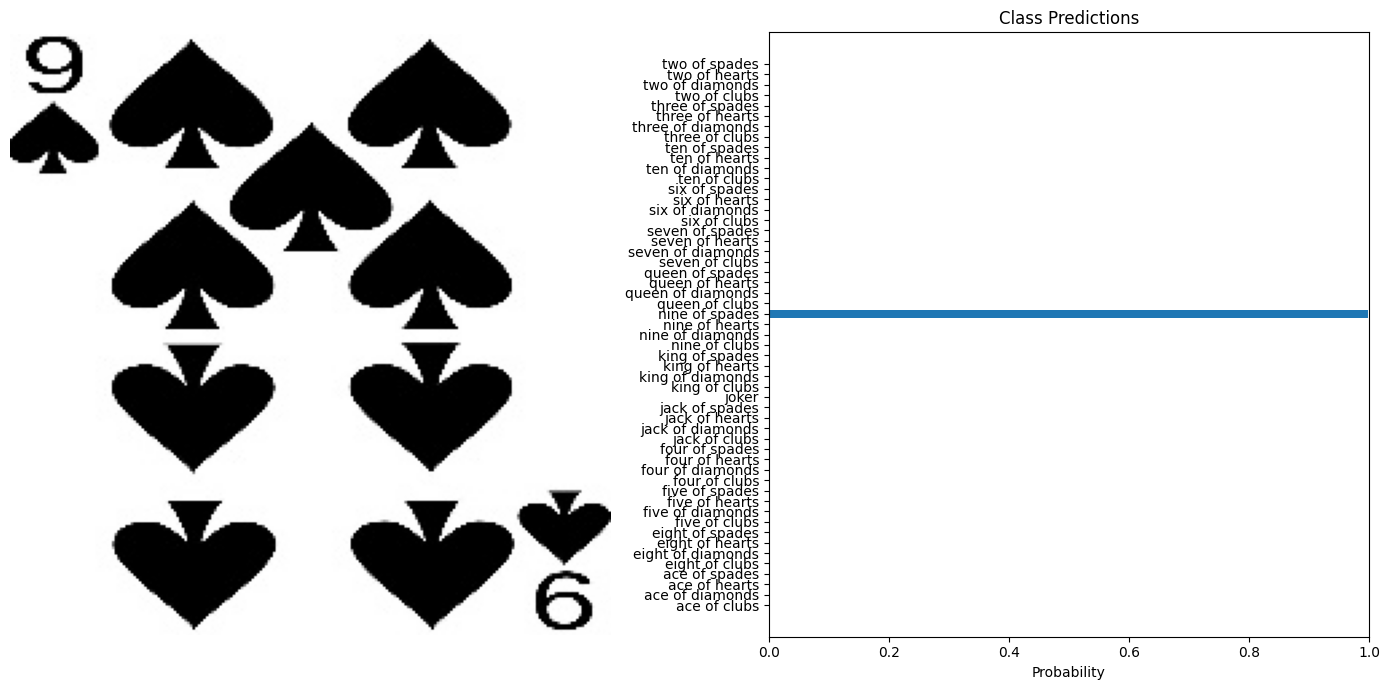

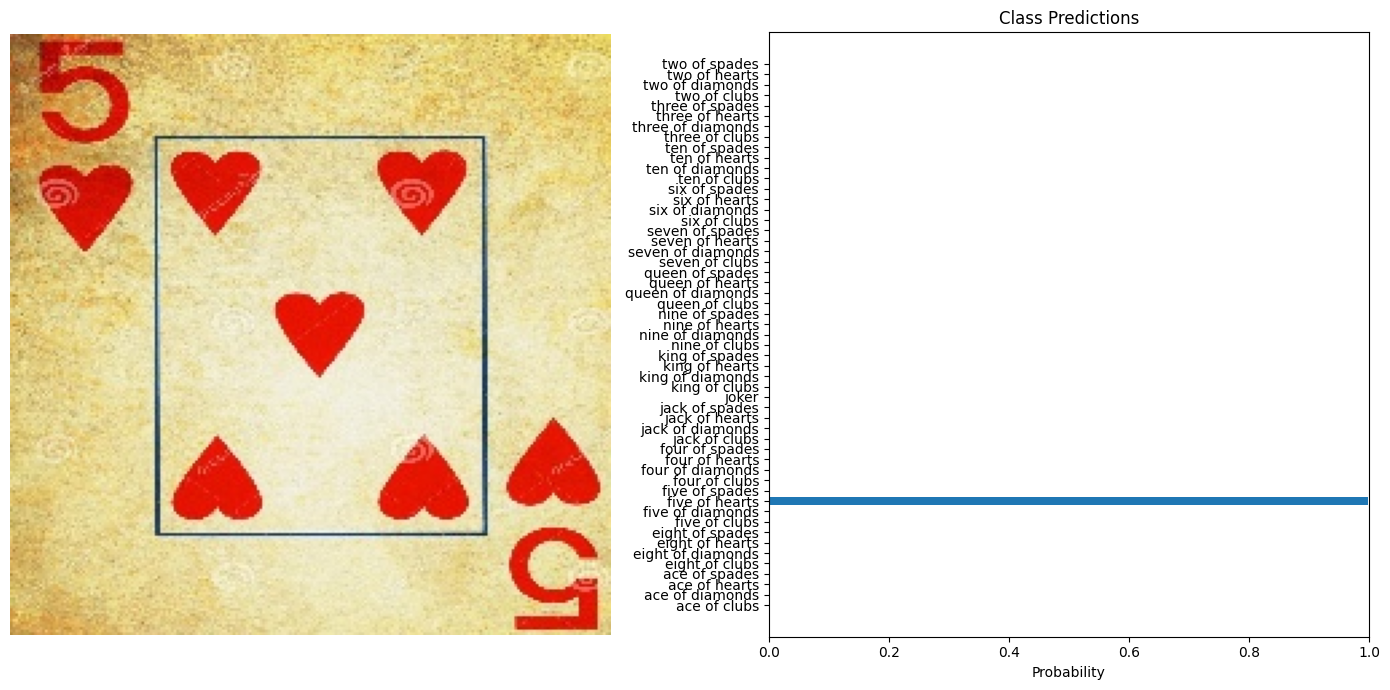

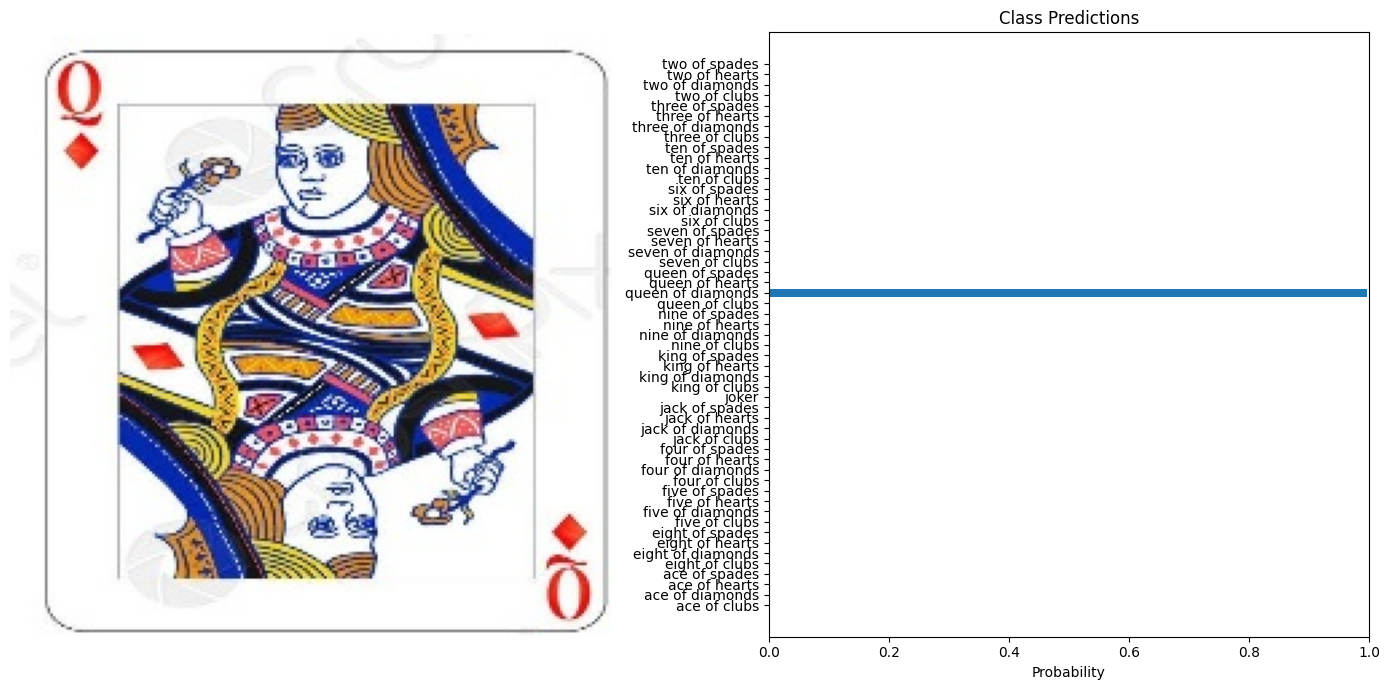

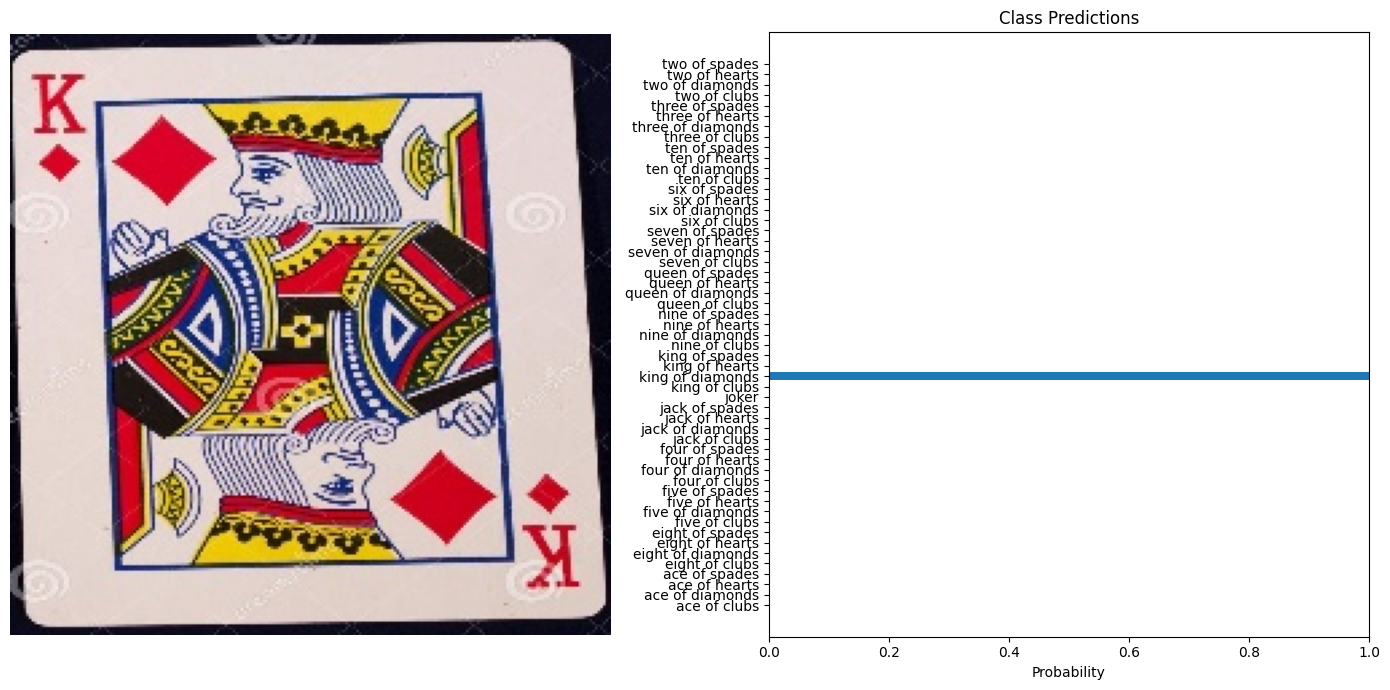

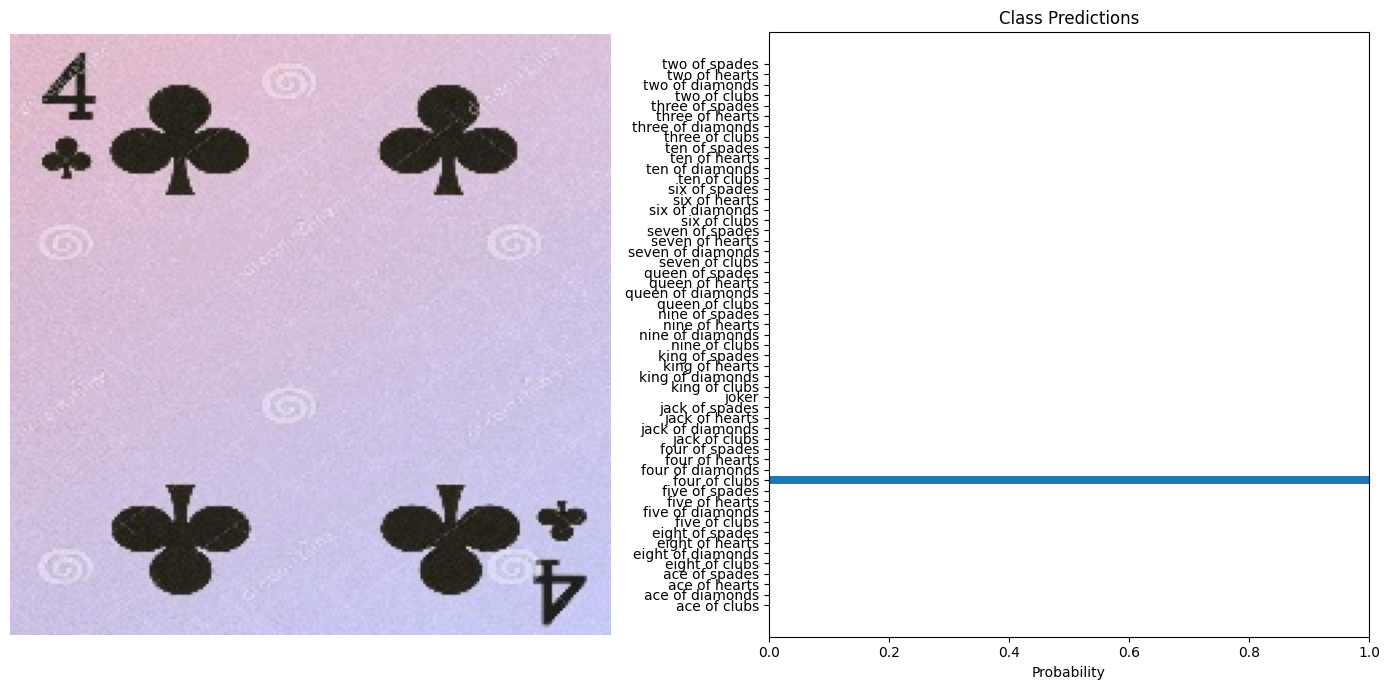

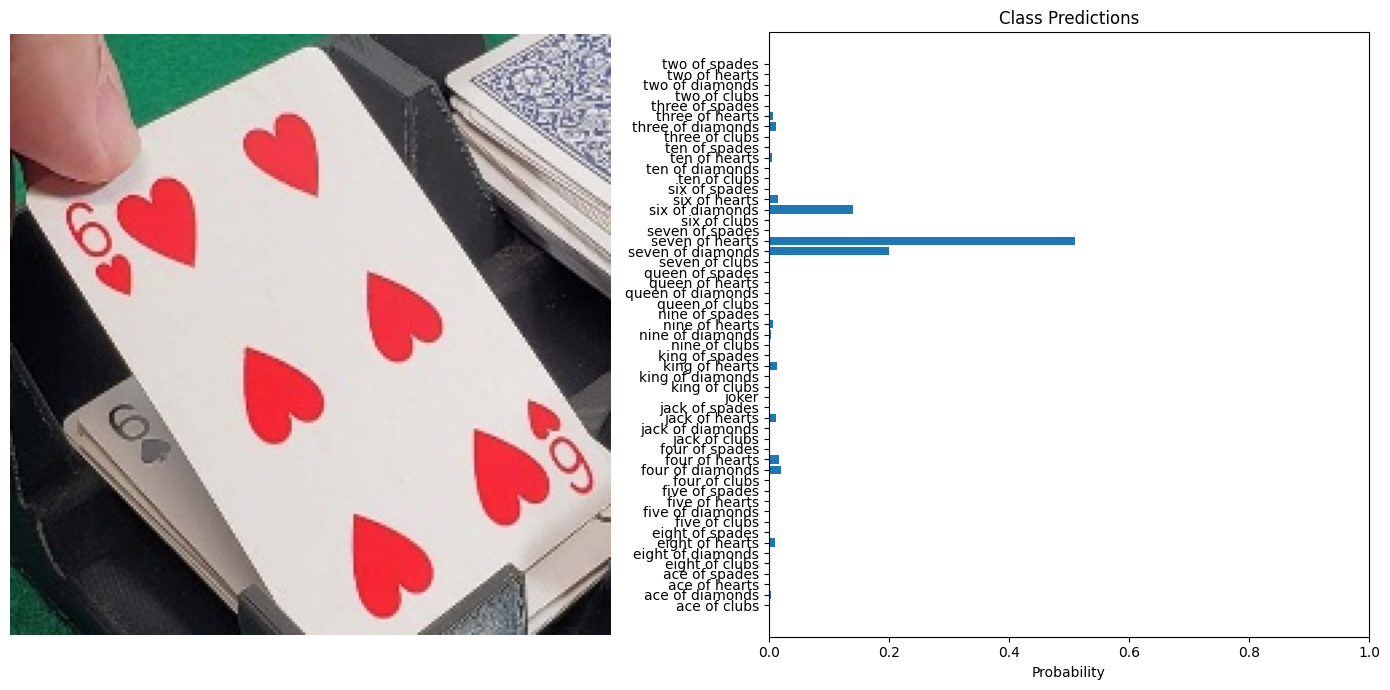

In [85]:
from glob import glob
test_images = glob('cards/test/*/*')
test_examples = np.random.choice(test_images, 10)

for example in test_examples:
  original_image, image_tensor = preprocess_image(example, transform)
  probabilities = predict(model, image_tensor, device)

  class_names = dataset.classes
  visualize_predictions(original_image, probabilities, class_names)